In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
index_names = ['unit_num', 'time_cycles']
setting_names = ['setting1', 'setting2', 'setting3']
sensor_names = ['sensor{}'.format(i) for i in range(1, 22)] 
col_names = index_names + setting_names + sensor_names

train = pd.read_csv('train_FD001.txt', sep='\s+', header=None, names=col_names)
test = pd.read_csv('test_FD001.txt', sep='\s+', header=None, names=col_names)
y_test = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])
train.head()

<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
C:\Users\akshi\AppData\Local\Temp\ipykernel_19144\2053653385.py:6: SyntaxWarning: invalid escape sequence '\s'
  train = pd.read_csv('train_FD001.txt', sep='\s+', header=None, names=col_names)
C:\Users\akshi\AppData\Local\Temp\ipykernel_19144\2053653385.py:7: SyntaxWarning: invalid escape sequence '\s'
  test = pd.read_csv('test_FD001.txt', sep='\s+', header=None, names=col_names)
C:\Users\akshi\AppData\Local\Temp\ipykernel_19144\2053653385.py:8: SyntaxWarning: invalid escape sequence '\s'
  y_test = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])


,unit_num,time_cycles,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


## To find the max cycles per engine till failure

In [3]:
n_cycles = train[index_names].groupby('unit_num').count()

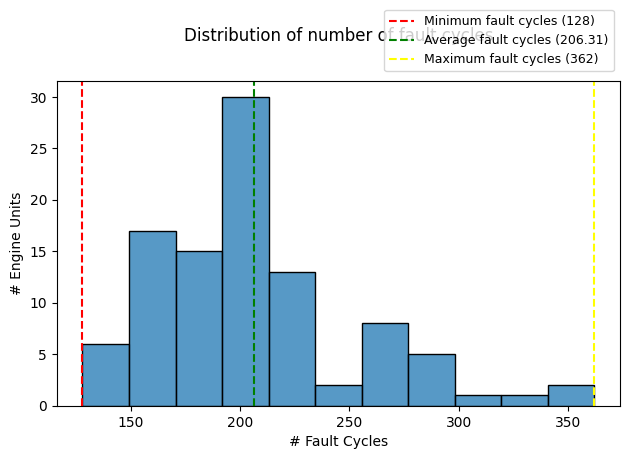

In [4]:
hist = sns.histplot(data=n_cycles, x="time_cycles")
hist.axvline(n_cycles.time_cycles.min(), color="red", label=f"Minimum fault cycles ({n_cycles.time_cycles.min()})", ls="--")
hist.axvline(n_cycles.time_cycles.mean(), color="green", label=f"Average fault cycles ({round(n_cycles.time_cycles.mean(), 2)})", ls="--")
hist.axvline(n_cycles.time_cycles.max(), color="yellow", label=f"Maximum fault cycles ({n_cycles.time_cycles.max()})", ls="--")

plt.ylabel("# Engine Units")
plt.xlabel("# Fault Cycles")
plt.legend(ncol=1, loc="upper right", bbox_to_anchor=[1, 1.24], fontsize=9)
plt.title("Distribution of number of fault cycles", y=1.1)

plt.tight_layout()
plt.show()

We can see that most engines fail after 200 cycles

## Since we only have the y_test RUL we have to find the RUL for each unit in the train dataset
the remaining useful time is the total cycles it can last minus the currecnt cycle it is on

In [5]:
def add_remaining_useful_life(df):
    
    result_frame = df.merge(n_cycles.rename(columns={"time_cycles": "n_cycles"}),
                            left_on='unit_num', right_index=True)
    remaining_useful_life = result_frame["n_cycles"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    result_frame = result_frame.drop("n_cycles", axis=1)
    return result_frame
  
train = add_remaining_useful_life(train)
train.head()

,unit_num,time_cycles,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


#### Now can check which sensors are actually useful by analyzing their trends and remove the ones not affecting failure

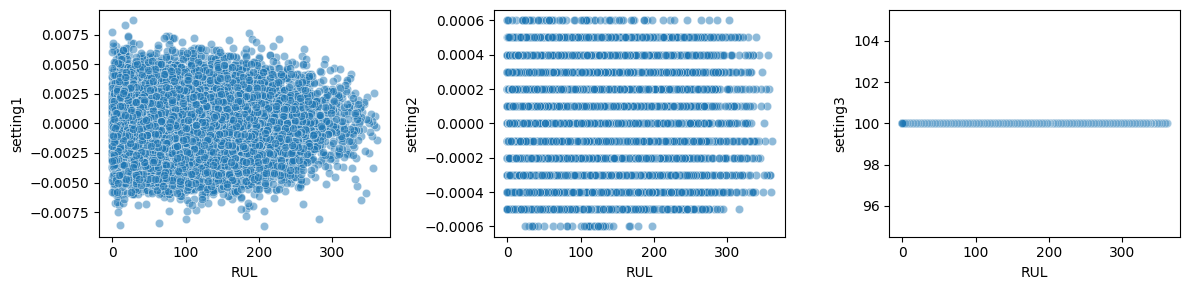

In [6]:
min_rul = train.RUL.min()
max_rul = train.RUL.max()
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

for i, s in enumerate(setting_names):
    sns.scatterplot(data=train, x="RUL", y=s, ax=axes[i], alpha=0.5)


plt.tight_layout()
plt.show()

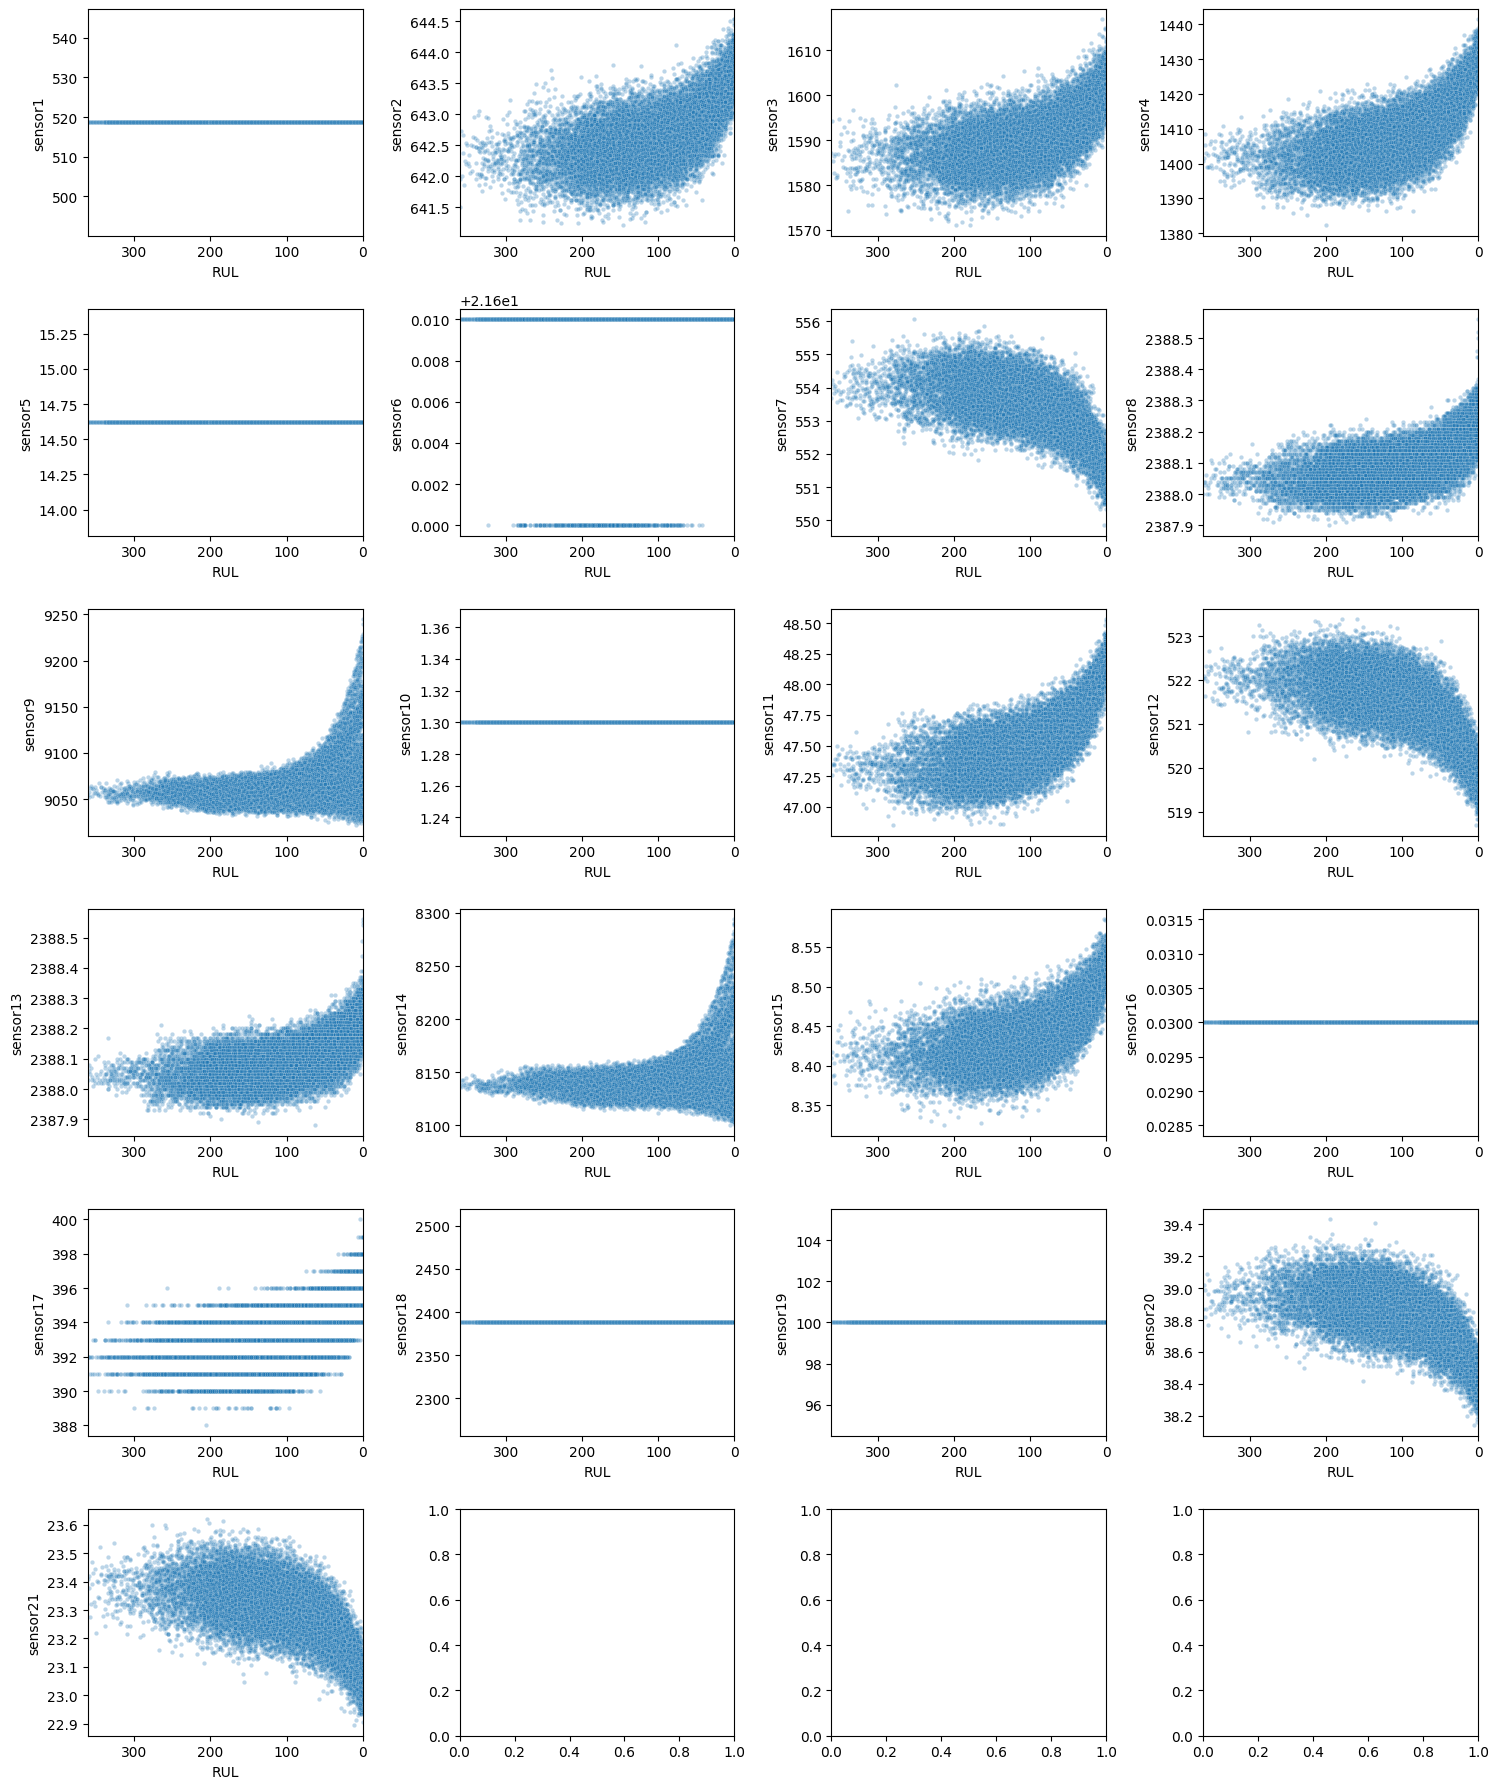

In [7]:
sensor_names = [f"sensor{i+1}" for i in range(21)]

fig, axes = plt.subplots(6, 4, figsize=(15, 18))

for i, s in enumerate(sensor_names):
    sns.scatterplot(data=train, x="RUL", y=s, ax=axes[i//4, i%4], alpha=0.3, s=10)
    axes[i//4, i%4].set_xlim(max_rul, min_rul)


plt.tight_layout()
plt.show()

## we can see that the 1st 2 operation settings give no real meaning to us while the 3rd one is constant hence they can be removed
## for the sensors we can see that sensors 1, 5, 10, 16, 18 and 19 are constant and 6 gives us no real information hence they too can be removed

In [8]:
del_cols = ["setting1", "setting2", "setting3"]

In [9]:
del_cols += ["sensor1", "sensor5", "sensor10", "sensor16", "sensor18", "sensor19","sensor6"]

## Sensor9 and Sensor 14 have very similar scatter plots they could be highly correlated

In [10]:
train[["sensor9", "sensor14"]].corr()

,sensor9,sensor14
sensor9,1.000000,0.963157
sensor14,0.963157,1.000000


### 0.96 correlation is very high so we should drop 1 of them

In [11]:
del_cols.append("sensor14")

We can also delete the columns unit and time cycles as they will only interfere with the model training

In [13]:
del_cols += index_names

### the deletion from both train and test datasets

In [15]:
X_train = train.drop(del_cols, axis=1)
y_train = X_train.pop('RUL')

X_test = test.groupby('unit_num').last().reset_index().drop(del_cols, axis=1)

# Since the sensor values have different ranges we can apply Z-score scaling (StandardScaler in python)

In [16]:
scaler = StandardScaler()
X_train = pd.DataFrame(data=scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=X_test.columns)

# <b> Model Training</b>

## Ideally Random forest should work better for this dataset as it contains non-linearity, sensor noise, and feature interactions and will avoid overfitting of the data

Test R² Score: 0.41235792359073764


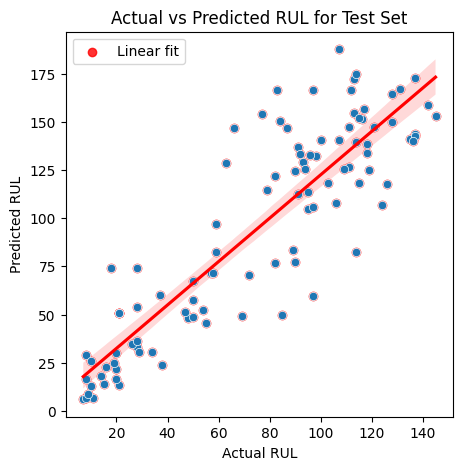

In [18]:
model = RandomForestRegressor(max_depth=8, random_state=42, n_jobs=15)
model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)

r2_test = r2_score(y_test, y_pred_test)
print("Test R² Score:", r2_test)

# Plot actual vs predicted RUL
plt.figure(figsize=(5, 5))
sns.regplot(x=y_test.RUL.values, y=y_pred_test, color='red', label="Linear fit")
sns.scatterplot(x=y_test.RUL.values, y=y_pred_test)

plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title("Actual vs Predicted RUL for Test Set")
plt.show()

## From cell 7 we can see that the RUL stays constant for a while and in cell 4 it can be seen that the failure starts at 128 therefore we can also clip the data after that

In [19]:
y_train_clipped = y_train.clip(upper=125)

Test R² Score: 0.8011442738156118


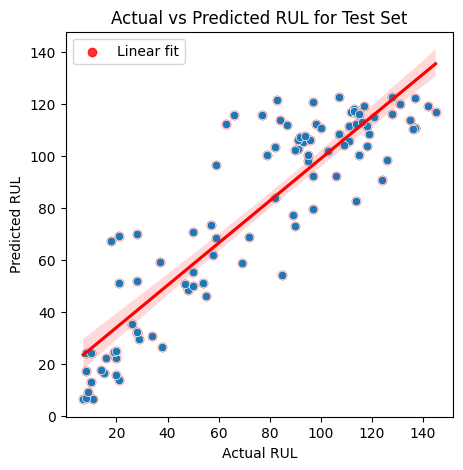

In [20]:
model = RandomForestRegressor(max_depth=8, random_state=42, n_jobs=15)
model.fit(X_train, y_train_clipped)

y_pred_test = model.predict(X_test)

r2_test = r2_score(y_test, y_pred_test)
print("Test R² Score:", r2_test)

# Plot actual vs predicted RUL
plt.figure(figsize=(5, 5))
sns.regplot(x=y_test.RUL.values, y=y_pred_test, color='red', label="Linear fit")
sns.scatterplot(x=y_test.RUL.values, y=y_pred_test)

plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title("Actual vs Predicted RUL for Test Set")
plt.show()

## <b>The R2 increased by 105%</b>

We can also try other models recommended for these kinds of data like xg boost

In [21]:
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train_clipped)
y_pred = xgb.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("XGB RMSE:", rmse)
print("XGB R²:", r2)

XGB RMSE: 314.4278869628906
XGB R²: 0.8179203271865845


we can get the important features using xgboost

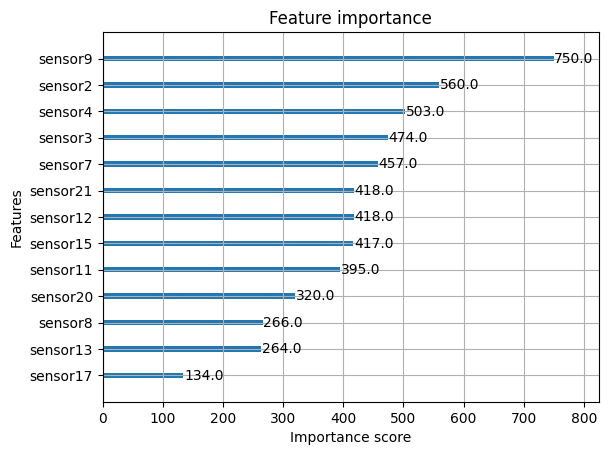

In [23]:
from xgboost import plot_importance
plot_importance(xgb)
plt.show()